<a href="https://colab.research.google.com/github/JanMeow/productDataOptimization/blob/main/Chapter1_product_data_analysis_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Anaylsis
For this notebook, we will
1. Sample the data for faster calculation
2.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
!git clone https://github.com/JanMeow/productDataOptimization.git

Cloning into 'productDataOptimization'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 9 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (9/9), 719.42 KiB | 19.44 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import time
from functools import wraps
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"⏱️ Function `{func.__name__}` took {end - start:.4f} seconds")
        return result
    return wrapper

In [ ]:
import pandas as pd
import numpy as np

# Load Excel and sheet names
def load_excel_data(excel_file):
  sheet_data = {}
  excel_file = "productDataOptimization/data.xlsx"
  xls = pd.ExcelFile(excel_file)
  sheet_keys = xls.sheet_names
  for sheet_name in sheet_keys:
      df_raw = pd.read_excel(excel_file, sheet_name=sheet_name, header=None)

      # Extract material names from row 3
      raw_material_names = df_raw.iloc[3, 1:].dropna().tolist()
      raw_material_names = [str(name).strip() for name in raw_material_names]
      start_col = 1

      # Track seen keys and build unique names
      name_counts = {}
      final_material_names = []

      for name in raw_material_names:
          if name not in name_counts:
              name_counts[name] = 1
              final_material_names.append(name)
          else:
              name_counts[name] += 1
              final_material_names.append(f"{name}{name_counts[name]}")

      # --- Extract df_0 (properties like Lambda-Wert) ---
      properties_rows = [4, 5]
      properties = []

      for row in properties_rows:
          row_label = df_raw.iloc[row, 0]
          values = df_raw.iloc[row, start_col::2].values[:len(final_material_names)]
          properties.append([row_label] + list(values))

      df_0 = pd.DataFrame(properties, columns=["Property"] + final_material_names)

      # Convert each column (excluding 'Property') into a numpy array
      data_0 = {}
      for material in df_0.columns[1:]:
        values = df_0[material].to_numpy()
        data_0[material] = values

      # --- Extract df_1 as dict of np arrays ---
      data_1 = {}
      name_counts = {}  # Reset to reassign same renaming logic for df_1

      for i, base_name in enumerate(raw_material_names):
          col_thickness = start_col + i * 2
          col_price = col_thickness + 1

          # Get group of entries
          group = []
          for row in range(8, df_raw.shape[0]):
              dicke = df_raw.iloc[row, col_thickness]
              preis = df_raw.iloc[row, col_price]
              if isinstance(dicke, str) or isinstance(preis, str):
                  continue
              if pd.notna(dicke) and pd.notna(preis):
                  group.append([dicke, preis])

          # Rename key consistently
          if base_name not in name_counts:
              name_counts[base_name] = 1
              final_key = base_name
          else:
              name_counts[base_name] += 1
              final_key = f"{base_name}{name_counts[base_name]}"

          if group:
              data_1[final_key] = np.array(group)

      # Store result
      sheet_data[sheet_name] = {
          "properties": data_0,
          "variants": data_1
      }
  return sheet_data


In [ ]:
excel_path = "productDataOptimization/data.xlsx"
sheet_data = load_excel_data(excel_path)

In [ ]:
sheet_data["Aussenwand 1.1"]["variants"]

{'Fassade': array([[ 71, 140]]),
 'Spundschalung': array([[22, 28],
        [25, 30],
        [27, 34]]),
 'Konstruktion': array([[160,  40],
        [180,  43],
        [200,  48],
        [220,  50],
        [240,  53],
        [260,  55],
        [280,  61],
        [300,  64],
        [320,  66],
        [340,  68],
        [360,  71]]),
 'Zellulosefaserdämmung': array([[160,  24],
        [180,  26],
        [200,  29],
        [220,  32],
        [240,  35],
        [260,  38],
        [280,  41],
        [300,  44],
        [320,  47],
        [340,  50],
        [360,  53]]),
 'Gipsfaserplatte': array([[10. , 28. ],
        [12.5, 29. ],
        [15. , 32. ],
        [18. , 35. ]])}

In [ ]:
from itertools import product
def get_combinations(data, return_type = "index", sampling_method = None):
  #Logic of filter data now is if that layer has more than 5 variants, get only half of it.
  if return_type == "index":
    if sampling_method == "vertical":
      thickness_lists = [list(range(len(layer)))[::2] if len(layer)> 5 else list(range(len(layer))) for layer in data.values()]
    if sampling_method == "horizontal":
      thickness_lists = [list(range(len(layer)))[::2] if "Zellulosefaserdämmung" not in key else list(range(len(layer))) for key, layer in data.items()]
  else:
    if sampling_method == "vertical":
      thickness_lists = [layer[:, 0][::2] if len(layer)> 5 else layer[:, 0] for layer in data.values()]
    if sampling_method == "horizontal":
      thickness_lists = [layer[:, 0][::2] if "Zellulosefaserdämmung" not in key else layer[:, 0] for key, layer in data.items()]
  return np.array(list(product(*thickness_lists)))

In [ ]:
factors = ["thickness", "price", "U_value", "fire_rating", "acoustics"]

def get_U_values(layers, thicknesses, lambdas, rsi = 0.13, rse = 0.04):
  omitted = ["Fassade", "Konstruktion"]
  mask = [not any(keyword in l for keyword in omitted) for l in layers]
  #thickness/1000 because of lambda unit takes on meter
  partial_u = thicknesses.copy()[mask]/lambdas[mask]/ 1000
  return round(1/(rse + np.sum(partial_u) +rsi),5)

def get_overall_VKF(data):
  rfs = [int(props[1][-1]) for props in data["properties"].values()]
  #0. certain rules apply
  #1. if all layers take the same rf then the overall assembly has the same rf
  #2. if not, take the lowest rfs, programmtically we just always takes the lowest rfs
  #3. the rfs of the construction layer is detemriend by the layers before and after it, take the lowest rfs for the 2
  #4. Second thought the second logic is useless, cause at the end its the lowest one of the layers that matter. ??? Should ask

  for i, layer in enumerate(data["properties"].keys()):
    if "Konstruktion" in layer:
      rf_prev = rfs[i-1]
      rf_next = rfs[i+1]
      # the bigger the value, the worse it is, idea is to take the worse
      if rf_prev > rf_next:
        rfs[i] = rf_prev
      else:
        rfs[i] = rf_next
  return max(rfs)


def get_performance_factors(combinations, data, factors):
  performances = np.zeros((len(combinations), len(factors)))
  properties = data["properties"]
  variants = data["variants"]
  layers = list(variants.keys())
  for i, combination in enumerate(combinations):
    thicknesses = np.array([variants[layers[i]][c][0] for i, c in enumerate(combination)])
    # overall thickness calculations excludes konstruction layer
    thickness_mask = [False if "Konstruktion" in props else True for props in properties.keys()]
    lambdas = np.array([ p[0] for p in properties.values()])
    U_value = get_U_values(layers, thicknesses, lambdas)
    row = performances[i]
    thickness = np.sum(thicknesses[thickness_mask])
    price = np.sum([variants[layers[i]][c][1] for i, c in enumerate(combination)])
    row[0], row[1], row[2] = thickness, price, U_value
  return performances

In [ ]:
@timeit
def get_all_perfromances(sheet_data, factors, sampling_method = None):
  total_combinations = 0
  for wall, data in sheet_data.items():
    print(wall)
    overall_VKF = get_overall_VKF(data)
    print(overall_VKF)
    combinations = get_combinations(data["variants"], return_type= "index", sampling_method = sampling_method)
    performancees = get_performance_factors(combinations, data, factors)
    data["performances"] = performancees
    total_combinations += len(combinations)
  return

In [ ]:
get_all_perfromances(sheet_data, factors, sampling_method= "vertical")

Aussenwand 1.1
3
Aussenwand 1.2
3
Aussenwand 1.3
3
Aussenwand 1.7
3
Aussenwand 1.8
3
⏱️ Function `get_all_perfromances` took 5.1541 seconds


In [ ]:
sheet_data["Aussenwand 1.1"]["performances"]

array([[2.6300e+02, 2.6000e+02, 2.1829e-01, 0.0000e+00, 0.0000e+00],
       [2.6550e+02, 2.6100e+02, 2.1792e-01, 0.0000e+00, 0.0000e+00],
       [2.6800e+02, 2.6400e+02, 2.1755e-01, 0.0000e+00, 0.0000e+00],
       ...,
       [4.7050e+02, 3.2700e+02, 1.0111e-01, 0.0000e+00, 0.0000e+00],
       [4.7300e+02, 3.3000e+02, 1.0103e-01, 0.0000e+00, 0.0000e+00],
       [4.7600e+02, 3.3300e+02, 1.0093e-01, 0.0000e+00, 0.0000e+00]])

In [ ]:
def get_global_bounds(sheet_data):
    all_thickness = []
    all_price = []
    all_u_value = []

    for key in sheet_data:
        data = sheet_data[key]["performances"]
        if data.shape[1] >= 3:  # Ensure at least 3 columns
            all_thickness.append(data[:, 0])
            all_price.append(data[:, 1])
            all_u_value.append(data[:, 2])

    # Concatenate all data
    thickness_all = np.concatenate(all_thickness)
    price_all = np.concatenate(all_price)
    u_value_all = np.concatenate(all_u_value)

    return {
        "thickness": (thickness_all.min(), thickness_all.max()),
        "price": (price_all.min(), price_all.max()),
        "u_value": (u_value_all.min(), u_value_all.max())
    }

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from IPython.display import display

def interactive_3d_plot_3(sheet_data, t_tol=20, u_tol=0.1):
    look_keys = list(sheet_data.keys())
    min_max_global = get_global_bounds(sheet_data)

    # ---------- inner plotting callback ----------
    def update(key="Aussenwand 1.1",
               t_thresh=0, p_thresh=0, u_thresh=0,
               t_tol=t_tol, u_tol=u_tol):

        data_array = sheet_data[key]["performances"]
        thickness, price, u_value = data_array[:, 0], data_array[:, 1], data_array[:, 2]

        mask = (np.abs(thickness - t_thresh) <= t_tol) & \
               (price <= p_thresh) & \
               (np.abs(u_value - u_thresh) <= u_tol)

        good = data_array[mask]
        bad  = data_array[~mask]

        # ------------ start figure ---------------
        fig = plt.figure(figsize=(11, 9))
        ax  = fig.add_subplot(111, projection='3d')

        # Main scatter
        ax.scatter(good[:, 0], good[:, 1], good[:, 2],
                   c='green', label='Meets req', zorder=2)
        ax.scatter(bad[:, 0],  bad[:, 1],  bad[:, 2],
                   c='red',   label='Fails req', zorder=1)

        # ----- highlight min & max price among valid points -----
        if good.size:
            min_idx, max_idx = np.argmin(good[:, 1]), np.argmax(good[:, 1])
            pt_min, pt_max   = good[min_idx], good[max_idx]

            h_min = ax.scatter(*pt_min[:3], c='yellow', s=90,
                               marker='o', edgecolors='k', zorder=5,
                               label=f"Min CHF {pt_min[1]:.0f}")
            h_max = ax.scatter(*pt_max[:3], c='blue', s=90,
                               marker='o', edgecolors='k', zorder=5,
                               label=f"Max CHF {pt_max[1]:.0f}")

            # Figure text (upper-left in figure coordinates)
            # fig.text(0.02, 0.96,
            #          f"Min price: {pt_min[1]:.1f}  |  "
            #          f"Max price: {pt_max[1]:.1f}  (CHF/m²)",
            #          color='blue', fontsize=10, weight='bold')

        # Threshold guide lines
        ax.plot([t_thresh]*2, [price.min(), price.max()], [u_thresh]*2, 'r--', zorder=0)
        ax.plot([thickness.min(), thickness.max()], [p_thresh]*2, [u_thresh]*2, 'r--', zorder=0)
        ax.plot([t_thresh]*2, [p_thresh]*2, [u_value.min(), u_value.max()], 'r--', zorder=0)

        ax.set_xlabel("Thickness [mm]")
        ax.set_ylabel("Price [CHF/m²]")
        ax.set_zlabel("U-Value [W/m²K]")
        ax.set_title(f"Performance – {key}")
        ax.legend(loc='upper right')
        plt.show()
    # ----------- widgets ----------------
    key_dropdown = widgets.Dropdown(options=look_keys, description='Aussenwand')

    t_slider = widgets.IntSlider(
        value=400, min=int(min_max_global["thickness"][0]),
        max=int(min_max_global["thickness"][1]), step=10,
        description='Tar_Thickness')

    p_slider = widgets.IntSlider(
        value=int(min_max_global["price"][1]), min=int(min_max_global["price"][0]),
        max=int(min_max_global["price"][1]), step=10,
        description='Max_Price')

    u_slider = widgets.FloatSlider(
        value=0.20, min=round(float(min_max_global["u_value"][0]), 3),
        max=round(float(min_max_global["u_value"][1]), 2), step=0.005,
        description='Tar_U-Value')

    t_tol_slider = widgets.IntSlider(value=t_tol, min=0, max=50, step=5,  description='t_tol')
    u_tol_slider = widgets.FloatSlider(value=u_tol, min=0, max=0.3, step=0.01, description='u_tol')

    display(widgets.interactive(
        update,
        key        = key_dropdown,
        t_thresh   = t_slider,
        p_thresh   = p_slider,
        u_thresh   = u_slider,
        t_tol      = t_tol_slider,
        u_tol      = u_tol_slider
    ))


In [ ]:
interactive_3d_plot_3(sheet_data, t_tol=20, u_tol=0.1)

interactive(children=(Dropdown(description='Aussenwand', options=('Aussenwand 1.1', 'Aussenwand 1.2', 'Aussenw…

# Observation
1. Sampling on the vertical axis causing unique U values to disappear since the removal of data is mostly on konstruction or dampung which has more than 5 variants, it means cetain U values are achievble only with these thicker layers
2. Data still share similar shape than the previous ones, so sampling can not happen vertically so maybe horizontally ?
3. We should do an anaylysis on frequent number that exsits in a specfic number in which U values plane

# Vertical Sampling

Before sampling, we should do a sanity check.
The question is what are the thicknesses in which layers that contributes to unique U value

In [ ]:
look_key = "Aussenwand 1.1"
data = sheet_data[look_key]["performances"]

In [ ]:
u_values_A1_1 = data[:,2].reshape(-1,1) # for k means
combinations_A1_1 = get_combinations(sheet_data["Aussenwand 1.1"]["variants"], return_type= "index", sampling_method = "vertical")

In [ ]:
bounds = np.min(u_values_A1_1), np.max(u_values_A1_1)
bounds

(np.float64(0.10093), np.float64(0.21829))

In [ ]:
combinations_A1_1

array([[ 0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  2],
       ...,
       [ 0,  2, 10, 10,  1],
       [ 0,  2, 10, 10,  2],
       [ 0,  2, 10, 10,  3]])

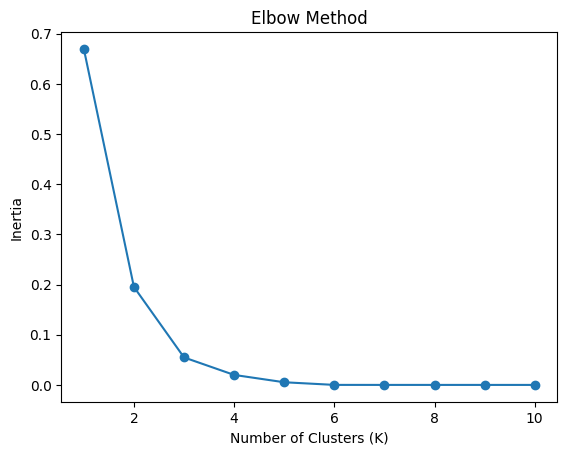

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(u_values_A1_1)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(u_values_A1_1)

In [ ]:
cluster_means = kmeans.cluster_centers_

In [ ]:
sorted_u_values_centroids = np.sort(cluster_means, axis = 0)
sorted_u_values_centroids

array([[0.10124917],
       [0.11332583],
       [0.12867583],
       [0.14883417],
       [0.176485  ],
       [0.21675333]])

In [ ]:
a_tol = 0.005
counts = [len(u_values_A1_1[abs(u_values_A1_1 - u_value) <= a_tol]) for u_value in sorted_u_values_centroids]
counts

[72, 72, 72, 72, 72, 72]

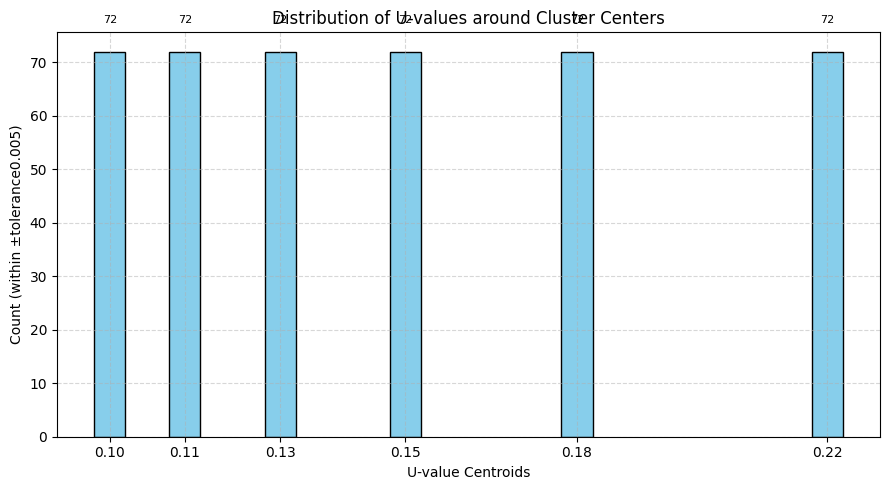

In [ ]:
centroids = sorted_u_values_centroids.flatten()
# Plot bar chart
plt.figure(figsize=(9, 5))
bar_width = 0.005  # Small width to avoid overlap

plt.bar(centroids, counts, width=bar_width, align='center', color='skyblue', edgecolor='black')

# Annotate counts on top
for x, y in zip(centroids, counts):
    plt.text(x, y + 5, str(y), ha='center', va='bottom', fontsize=8)

# Set x-axis ticks and labels with the U-values
plt.xticks(centroids, [f"{val:.2f}" for val in centroids])

plt.xlabel("U-value Centroids")
plt.ylabel(f"Count (within ±tolerance{a_tol})")
plt.title("Distribution of U-values around Cluster Centers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
a_tol = 0.01
look_key = "Aussenwand 1.1"
u_values = sheet_data[look_key]["performances"][:,2].flatten()
mask_indices = [np.where(abs(u_values - u_value) <= a_tol) for u_value in sorted_u_values_centroids]
combinations = get_combinations(sheet_data[look_key]["variants"], return_type= "index", sampling_method = "vertical")

In [ ]:
selected_combinations = [combinations[mask] for mask in mask_indices]

A remark to this is that because facade and constructions are ignored for the U value calculations, only columns [1,3,4] are considered

In [ ]:
selected_combinations[1][:10][:, [1,3,4]]

array([[0, 8, 0],
       [0, 8, 1],
       [0, 8, 2],
       [0, 8, 3],
       [0, 8, 0],
       [0, 8, 1],
       [0, 8, 2],
       [0, 8, 3],
       [0, 8, 0],
       [0, 8, 1]])

# Horizonral Sampling

In [ ]:
# sheet_data2 = load_excel_data(excel_path)
get_all_perfromances(sheet_data, factors, sampling_method= "horizontal")

Aussenwand 1.1
3
Aussenwand 1.2
3
Aussenwand 1.3
3
Aussenwand 1.7
3
Aussenwand 1.8
3
⏱️ Function `get_all_perfromances` took 0.5272 seconds


In [ ]:
interactive_3d_plot_3(sheet_data, t_tol=20, u_tol=0.1)

interactive(children=(Dropdown(description='Aussenwand', options=('Aussenwand 1.1', 'Aussenwand 1.2', 'Aussenw…

In [ ]:
look_key = "Aussenwand 1.3"

In [ ]:
data = sheet_data["Aussenwand 1.3"]["performances"]
u_values_A1_3 = data[:,2].reshape(-1,1) # for k means

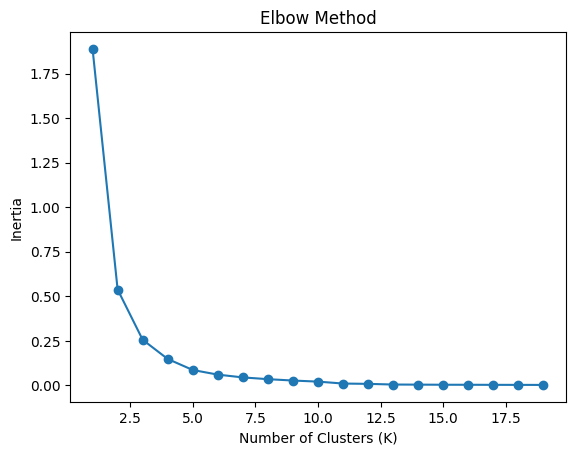

In [ ]:
inertias = []
K_range = range(1, 20)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(u_values_A1_3)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 20), inertias, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
inertias = np.array(inertias)
first_deriv = np.diff(inertias)
second_deriv = np.diff(first_deriv)

elbow_index = np.argmin(second_deriv) + 1  # +1 due to second diff offset
print("Elbow at:", elbow_index)

Elbow at: 9


In [ ]:
optimal_k = 9
kmeans = KMeans(n_clusters=optimal_k, random_state=0).fit(u_values_A1_3)
cluster_means = kmeans.cluster_centers_
sorted_u_values_centroids = np.sort(cluster_means, axis = 0)

In [ ]:
a_tol = 0.005
u_values = sheet_data[look_key]["performances"][:,2].flatten()
mask_indices = [np.where(abs(u_values - u_value) <= a_tol) for u_value in sorted_u_values_centroids]
combinations = get_combinations(sheet_data[look_key]["variants"], return_type= "index", sampling_method = "horizontal")

In [ ]:
counts = [len(u_values_A1_3[abs(u_values_A1_3 - u_value) <= a_tol]) for u_value in sorted_u_values_centroids]
counts

[384, 576, 576, 528, 312, 360, 240, 192, 96]

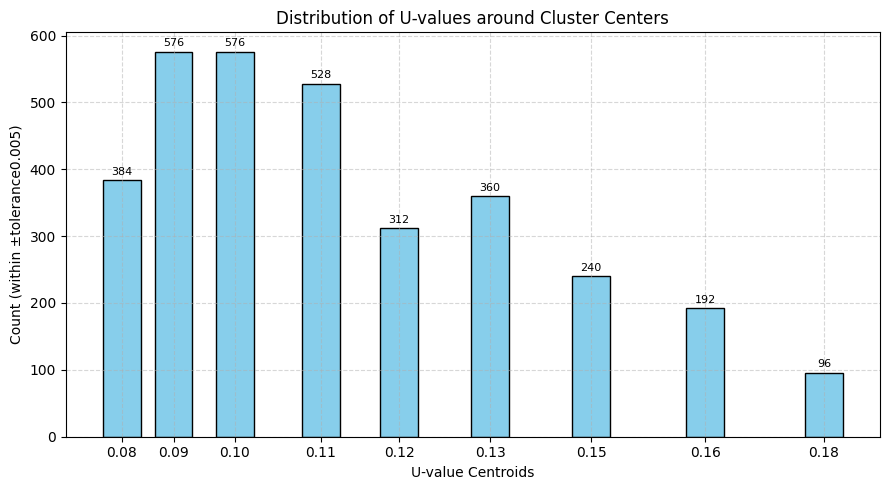

In [ ]:
centroids = sorted_u_values_centroids.flatten()
# Plot bar chart
plt.figure(figsize=(9, 5))
bar_width = 0.005  # Small width to avoid overlap

plt.bar(centroids, counts, width=bar_width, align='center', color='skyblue', edgecolor='black')

# Annotate counts on top
for x, y in zip(centroids, counts):
    plt.text(x, y + 5, str(y), ha='center', va='bottom', fontsize=8)

# Set x-axis ticks and labels with the U-values
plt.xticks(centroids, [f"{val:.2f}" for val in centroids])

plt.xlabel("U-value Centroids")
plt.ylabel(f"Count (within ±tolerance{a_tol})")
plt.title("Distribution of U-values around Cluster Centers")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()